In [254]:
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [200]:
# python3 App.py -u dataset/bach_chorals/
# python3 App.py -i dataset/bach_chorals/ -u dataset/shanxi/

In [147]:
data_dir = 'out/bach_chorals_notewise'

In [ ]:
data_dir = 'out/shanxi_notewise'

In [255]:
data_dir = 'out/bach_chorals_small_notewise'

In [256]:
# Load dataset based on data_dir
data = load_results(data_dir)

print(f"Dataset structure: {list(data.keys())}")
if data:
    first_key = list(data.keys())[0]
    print(f"First file structure: {data[first_key]}")
    # Check KL_ltm_per_order and JS_ltm_per_order length
    if first_key in data and 'pitch' in data[first_key]:
        first_note = data[first_key]['pitch'][0]
        kl_length = len(first_note['KL_ltm_per_order'])
        js_length = len(first_note['JS_ltm_per_order'])
        print(f"KL_ltm_per_order length: {kl_length}")
        print(f"JS_ltm_per_order length: {js_length}")

datasets = [(os.path.basename(data_dir.rstrip('_notewise')), data)]

Dataset structure: ['chor_003', 'chor_001', 'chor_005', 'chor_002', 'chor_004', '_meta_']
First file structure: {'pitch': [{'idx': 1, 'IC': 0.49999999999795963, 'Entropy': 0.0, 'KL_ltm_per_order': [-1.4428232973175177e-12, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'JS_ltm_per_order': [0.499999999979847, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, {'idx': 2, 'IC': 0.29248125035881123, 'Entropy': 0.5773502691896258, 'KL_ltm_per_order': [1.0, 39.86313713864835, 39.86313713864835, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'JS_ltm_per_order': [0.3112781244394799, 0.999999999959694, 0.999999999959694, 0.3112781244394799, 0.3112781244394799, 0.3112781244394799, 0.3112781244394799, 0.3112781244394799, 0.3112781244394799, 0.3112781244394799, 0.3112781244394799, 0.3112781244394799, 0.3112781244394799, 0.3112781244394799, 0.311278124

In [257]:
def load_results(path):
    # Handle case where path might be a dict (already loaded data)
    if isinstance(path, dict):
        return path
    
    if os.path.isdir(path):
        # find first .pickle file
        for fname in os.listdir(path):
            if fname.endswith('.pickle'):
                return pickle.load(open(os.path.join(path, fname), 'rb'))
        raise FileNotFoundError(f"No .pickle file found in directory {path}")
    else:
        return pickle.load(open(path, 'rb'))


def process_viewpoint_data(data):
    """Transform raw data into viewpoint-organized structure"""
    # Handle case where data is a string path instead of loaded data
    if isinstance(data, str):
        data = load_results(data)
    
    # Check for meta info and extract file order/piece starts
    if '_meta_' in data:
        meta = data['_meta_']
        file_order = meta.get('file_order', [])
        piece_starts = meta.get('piece_starts', [])
        # Remove meta from main data
        data = {k: v for k, v in data.items() if k != '_meta_'}
    else:
        file_order = list(data.keys())
        piece_starts = []
    
    viewpoint_data = {}
    current_position = 0
    song_starts = [0]  # Always start at position 0
    
    for song_name in file_order:
        if song_name not in data:
            continue
            
        views = data[song_name]
        song_length = 0
        
        for vp, notes in views.items():
            if vp not in viewpoint_data:
                viewpoint_data[vp] = {
                    'IC': [], 
                    'Entropy': [], 
                    'KL_ltm_mean': [],
                    'KL_ltm_std': [],
                    'JS_ltm_mean': [],
                    'JS_ltm_std': []
                }
            
            if isinstance(notes, list) and len(notes) > 0:
                first_note = notes[0]
                if isinstance(first_note, dict) and 'IC' in first_note:
                    viewpoint_data[vp]['IC'].extend([n['IC'] for n in notes])
                    viewpoint_data[vp]['Entropy'].extend([n['Entropy'] for n in notes])
                    
                    # Calculate mean and std for KL divergences
                    for n in notes:
                        if len(n['KL_ltm_per_order']) > 0:
                            kl_array = np.array(n['KL_ltm_per_order'])
                            viewpoint_data[vp]['KL_ltm_mean'].append(np.mean(kl_array))
                            viewpoint_data[vp]['KL_ltm_std'].append(np.std(kl_array))
                        else:
                            viewpoint_data[vp]['KL_ltm_mean'].append(0.0)
                            viewpoint_data[vp]['KL_ltm_std'].append(0.0)
                    
                    # Calculate mean and std for JS divergences
                    for n in notes:
                        if 'JS_ltm_per_order' in n and len(n['JS_ltm_per_order']) > 0:
                            js_array = np.array(n['JS_ltm_per_order'])
                            viewpoint_data[vp]['JS_ltm_mean'].append(np.mean(js_array))
                            viewpoint_data[vp]['JS_ltm_std'].append(np.std(js_array))
                        else:
                            viewpoint_data[vp]['JS_ltm_mean'].append(0.0)
                            viewpoint_data[vp]['JS_ltm_std'].append(0.0)
                    
                    if song_length == 0:
                        song_length = len(notes)
        
        current_position += song_length
        if current_position > song_starts[-1]:  # Only add if we actually advanced
            song_starts.append(current_position)
    
    return viewpoint_data, song_starts[:-1]  # Remove last position


def plot_viewpoint_metrics(data, viewpoint='pitch'):
    """Plot IC, Entropy, KL mean±std, and JS mean±std for a specific viewpoint"""
    # Process data
    viewpoint_data, song_starts = process_viewpoint_data(data)
    
    if viewpoint not in viewpoint_data:
        print(f"Viewpoint '{viewpoint}' not found. Available: {list(viewpoint_data.keys())}")
        return
    
    vp_data = viewpoint_data[viewpoint]
    
    # Create 4x1 subplot grid (separate rows for each metric)
    fig, axes = plt.subplots(4, 1, figsize=(20, 16))
    
    # 1. IC plot
    ax = axes[0]
    if len(vp_data['IC']) > 0:
        note_count = len(vp_data['IC'])
        x_axis = list(range(1, note_count + 1))
        ax.plot(x_axis, vp_data['IC'], color='blue', alpha=0.7, linewidth=1)
        
        # Add vertical lines for piece boundaries
        for start in song_starts[1:]:
            ax.axvline(x=start+1, color='red', linestyle='--', alpha=0.3)
    
    ax.set_title(f'{viewpoint} - Information Content')
    ax.set_xlabel('Note count')
    ax.set_ylabel('IC (bits)')
    ax.grid(True, alpha=0.3)
    
    # 2. Entropy plot
    ax = axes[1]
    if len(vp_data['Entropy']) > 0:
        note_count = len(vp_data['Entropy'])
        x_axis = list(range(1, note_count + 1))
        ax.plot(x_axis, vp_data['Entropy'], color='green', alpha=0.7, linewidth=1)
        
        # Add vertical lines for piece boundaries
        for start in song_starts[1:]:
            ax.axvline(x=start+1, color='red', linestyle='--', alpha=0.3)
    
    ax.set_title(f'{viewpoint} - Entropy')
    ax.set_xlabel('Note count')
    ax.set_ylabel('Entropy (bits)')
    ax.grid(True, alpha=0.3)
    
    # 3. KL divergence mean ± std
    ax = axes[2]
    if len(vp_data['KL_ltm_mean']) > 0:
        note_count = len(vp_data['KL_ltm_mean'])
        x_axis = list(range(1, note_count + 1))
        kl_mean = np.array(vp_data['KL_ltm_mean'])
        kl_std = np.array(vp_data['KL_ltm_std'])
        
        ax.plot(x_axis, kl_mean, color='red', alpha=0.8, linewidth=1, label='Mean KL')
        ax.fill_between(x_axis, kl_mean - kl_std, kl_mean + kl_std, 
                       color='red', alpha=0.2, label='±1 STD')
        
        # Add vertical lines for piece boundaries
        for start in song_starts[1:]:
            if start < note_count:
                ax.axvline(x=start+1, color='black', linestyle='--', alpha=0.3)
    
    ax.set_title(f'{viewpoint} - KL Divergence (Mean ± STD)')
    ax.set_xlabel('Note count')
    ax.set_ylabel('KL Divergence (bits)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. JS divergence mean ± std
    ax = axes[3]
    if len(vp_data['JS_ltm_mean']) > 0:
        note_count = len(vp_data['JS_ltm_mean'])
        x_axis = list(range(1, note_count + 1))
        js_mean = np.array(vp_data['JS_ltm_mean'])
        js_std = np.array(vp_data['JS_ltm_std'])
        
        ax.plot(x_axis, js_mean, color='purple', alpha=0.8, linewidth=1, label='Mean JS')
        ax.fill_between(x_axis, js_mean - js_std, js_mean + js_std, 
                       color='purple', alpha=0.2, label='±1 STD')
        
        # Add vertical lines for piece boundaries
        for start in song_starts[1:]:
            if start < note_count:
                ax.axvline(x=start+1, color='black', linestyle='--', alpha=0.3)
    
    ax.set_title(f'{viewpoint} - JS Divergence (Mean ± STD)')
    ax.set_xlabel('Note count')
    ax.set_ylabel('JS Divergence (bits)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


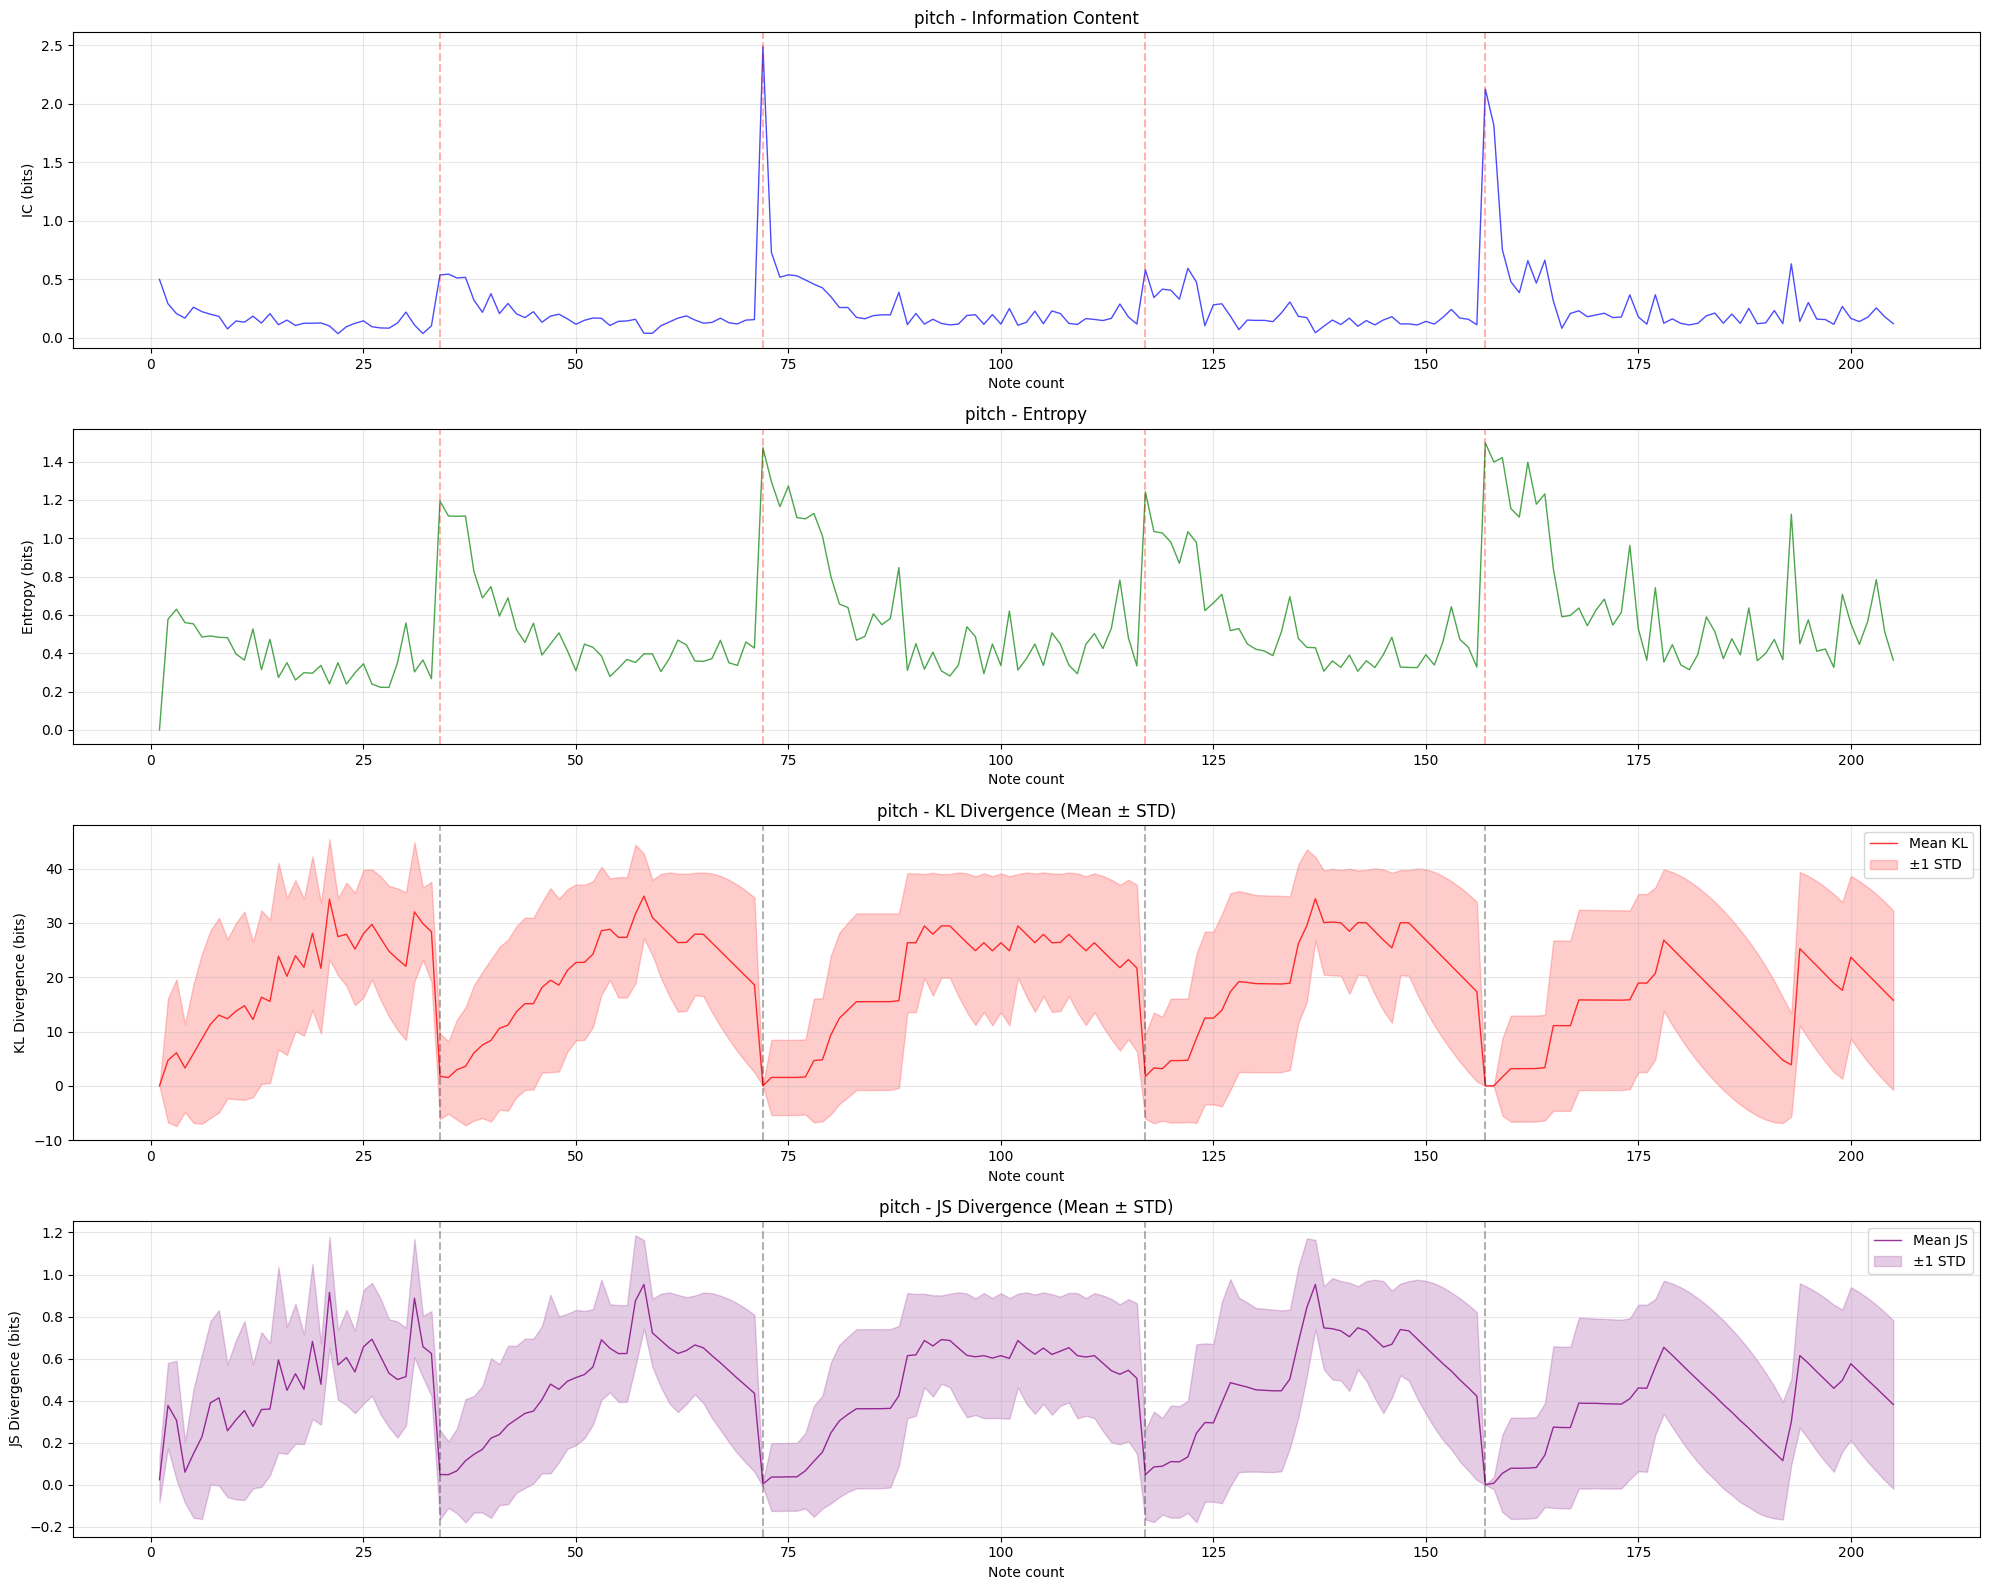

In [258]:
plot_viewpoint_metrics(data, viewpoint='pitch')

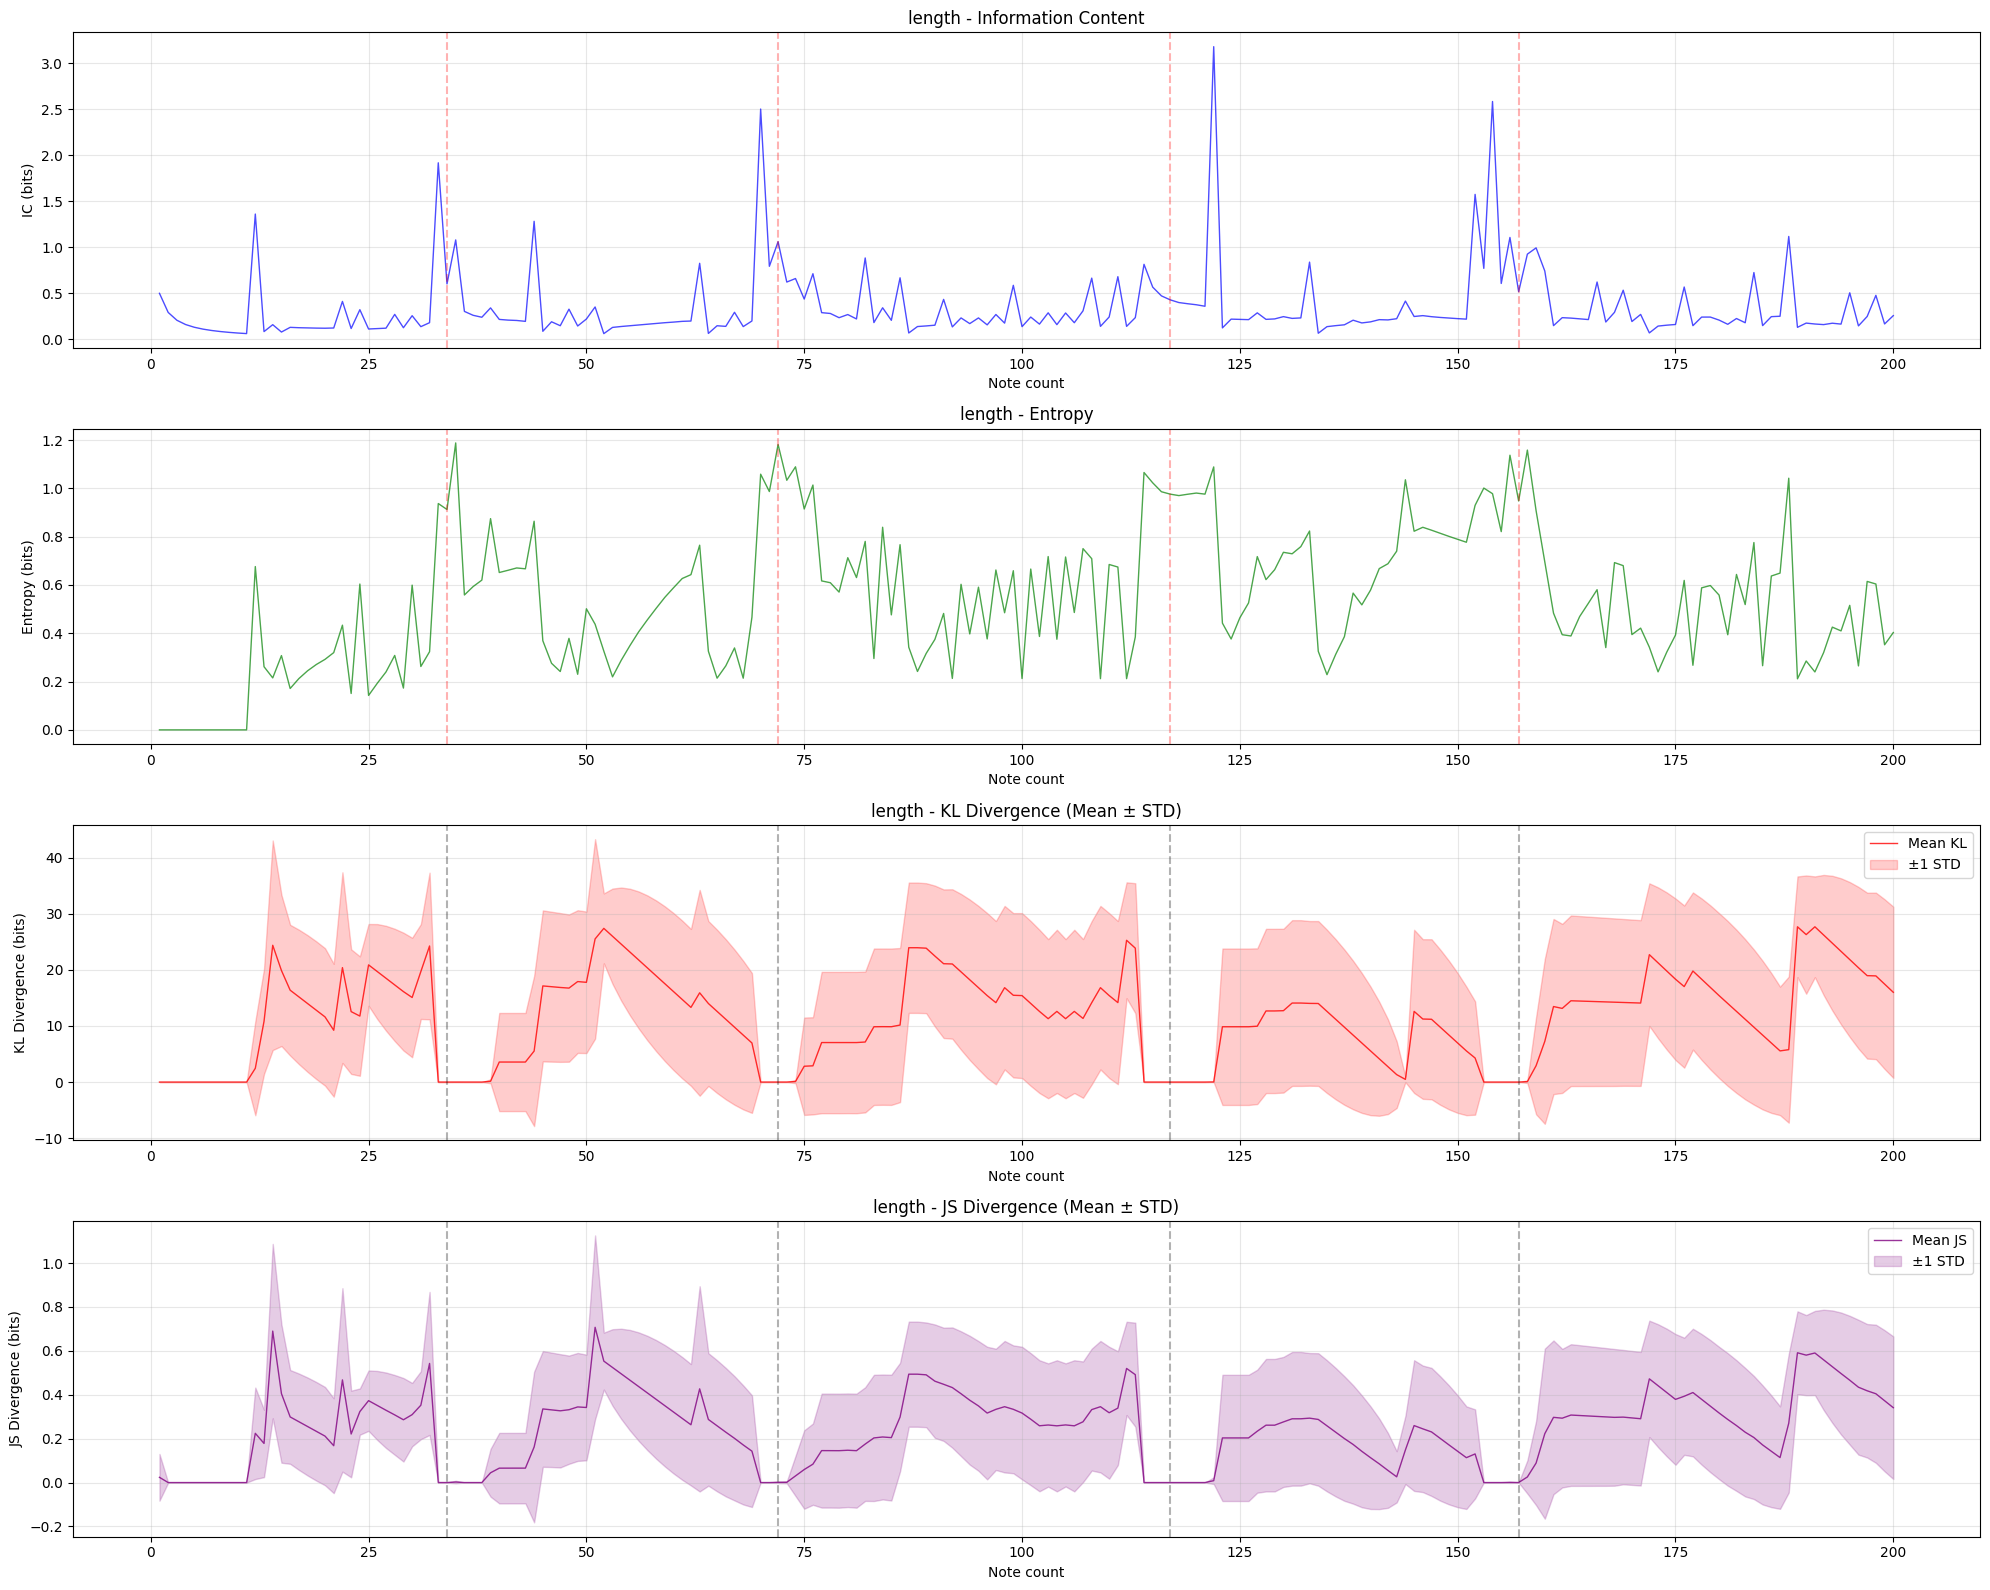

In [259]:
plot_viewpoint_metrics(data, viewpoint='length')

In [260]:
def load_results(path):
    # Handle case where path might be a dict (already loaded data)
    if isinstance(path, dict):
        return path
    
    if os.path.isdir(path):
        # find first .pickle file
        for fname in os.listdir(path):
            if fname.endswith('.pickle'):
                return pickle.load(open(os.path.join(path, fname), 'rb'))
        raise FileNotFoundError(f"No .pickle file found in directory {path}")
    else:
        return pickle.load(open(path, 'rb'))


def process_viewpoint_data(data):
    """Transform raw data into viewpoint-organized structure"""
    # Handle case where data is a string path instead of loaded data
    if isinstance(data, str):
        data = load_results(data)
    
    # Check for meta info and extract file order/piece starts
    if '_meta_' in data:
        meta = data['_meta_']
        file_order = meta.get('file_order', [])
        piece_starts = meta.get('piece_starts', [])
        # Remove meta from main data
        data = {k: v for k, v in data.items() if k != '_meta_'}
    else:
        file_order = list(data.keys())
        piece_starts = []
    
    viewpoint_data = {}
    current_position = 0
    song_starts = [0]  # Always start at position 0
    
    for song_name in file_order:
        if song_name not in data:
            continue
            
        views = data[song_name]
        song_length = 0
        
        for vp, notes in views.items():
            if vp not in viewpoint_data:
                viewpoint_data[vp] = {
                    'IC': [], 
                    'Entropy': [], 
                    'KL_ltm_mean': [],
                    'KL_ltm_std': [],
                    'JS_ltm_mean': [],
                    'JS_ltm_std': [],
                    'KL_ltm_per_order': [],
                    'JS_ltm_per_order': []
                }
            
            if isinstance(notes, list) and len(notes) > 0:
                first_note = notes[0]
                if isinstance(first_note, dict) and 'IC' in first_note:
                    viewpoint_data[vp]['IC'].extend([n['IC'] for n in notes])
                    viewpoint_data[vp]['Entropy'].extend([n['Entropy'] for n in notes])
                    
                    # Store raw per-order data
                    viewpoint_data[vp]['KL_ltm_per_order'].extend([n['KL_ltm_per_order'] for n in notes])
                    if 'JS_ltm_per_order' in first_note:
                        viewpoint_data[vp]['JS_ltm_per_order'].extend([n['JS_ltm_per_order'] for n in notes])
                    
                    # Calculate mean and std for KL divergences
                    for n in notes:
                        if len(n['KL_ltm_per_order']) > 0:
                            kl_array = np.array(n['KL_ltm_per_order'])
                            viewpoint_data[vp]['KL_ltm_mean'].append(np.mean(kl_array))
                            viewpoint_data[vp]['KL_ltm_std'].append(np.std(kl_array))
                        else:
                            viewpoint_data[vp]['KL_ltm_mean'].append(0.0)
                            viewpoint_data[vp]['KL_ltm_std'].append(0.0)
                    
                    # Calculate mean and std for JS divergences
                    for n in notes:
                        if 'JS_ltm_per_order' in n and len(n['JS_ltm_per_order']) > 0:
                            js_array = np.array(n['JS_ltm_per_order'])
                            viewpoint_data[vp]['JS_ltm_mean'].append(np.mean(js_array))
                            viewpoint_data[vp]['JS_ltm_std'].append(np.std(js_array))
                        else:
                            viewpoint_data[vp]['JS_ltm_mean'].append(0.0)
                            viewpoint_data[vp]['JS_ltm_std'].append(0.0)
                    
                    if song_length == 0:
                        song_length = len(notes)
        
        current_position += song_length
        if current_position > song_starts[-1]:  # Only add if we actually advanced
            song_starts.append(current_position)
    
    return viewpoint_data, song_starts[:-1]  # Remove last position


def plot_viewpoint_metrics(data, viewpoint='pitch'):
    """Plot IC, Entropy, KL mean±std, and JS mean±std for a specific viewpoint"""
    # Process data
    viewpoint_data, song_starts = process_viewpoint_data(data)
    
    if viewpoint not in viewpoint_data:
        print(f"Viewpoint '{viewpoint}' not found. Available: {list(viewpoint_data.keys())}")
        return
    
    vp_data = viewpoint_data[viewpoint]
    
    # Create 4x1 subplot grid (separate rows for each metric)
    fig, axes = plt.subplots(4, 1, figsize=(20, 16))
    
    # 1. IC plot
    ax = axes[0]
    if len(vp_data['IC']) > 0:
        note_count = len(vp_data['IC'])
        x_axis = list(range(1, note_count + 1))
        ax.plot(x_axis, vp_data['IC'], color='blue', alpha=0.7, linewidth=1)
        
        # Add vertical lines for piece boundaries
        for start in song_starts[1:]:
            ax.axvline(x=start+1, color='red', linestyle='--', alpha=0.3)
    
    ax.set_title(f'{viewpoint} - Information Content')
    ax.set_xlabel('Note count')
    ax.set_ylabel('IC (bits)')
    ax.grid(True, alpha=0.3)
    
    # 2. Entropy plot
    ax = axes[1]
    if len(vp_data['Entropy']) > 0:
        note_count = len(vp_data['Entropy'])
        x_axis = list(range(1, note_count + 1))
        ax.plot(x_axis, vp_data['Entropy'], color='green', alpha=0.7, linewidth=1)
        
        # Add vertical lines for piece boundaries
        for start in song_starts[1:]:
            ax.axvline(x=start+1, color='red', linestyle='--', alpha=0.3)
    
    ax.set_title(f'{viewpoint} - Entropy')
    ax.set_xlabel('Note count')
    ax.set_ylabel('Entropy (bits)')
    ax.grid(True, alpha=0.3)
    
    # 3. KL divergence mean ± std
    ax = axes[2]
    if len(vp_data['KL_ltm_mean']) > 0:
        note_count = len(vp_data['KL_ltm_mean'])
        x_axis = list(range(1, note_count + 1))
        kl_mean = np.array(vp_data['KL_ltm_mean'])
        kl_std = np.array(vp_data['KL_ltm_std'])
        
        ax.plot(x_axis, kl_mean, color='red', alpha=0.8, linewidth=1, label='Mean KL')
        ax.fill_between(x_axis, kl_mean - kl_std, kl_mean + kl_std, 
                       color='red', alpha=0.2, label='±1 STD')
        
        # Add vertical lines for piece boundaries
        for start in song_starts[1:]:
            if start < note_count:
                ax.axvline(x=start+1, color='black', linestyle='--', alpha=0.3)
    
    ax.set_title(f'{viewpoint} - KL Divergence (Mean ± STD)')
    ax.set_xlabel('Note count')
    ax.set_ylabel('KL Divergence (bits)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. JS divergence mean ± std
    ax = axes[3]
    if len(vp_data['JS_ltm_mean']) > 0:
        note_count = len(vp_data['JS_ltm_mean'])
        x_axis = list(range(1, note_count + 1))
        js_mean = np.array(vp_data['JS_ltm_mean'])
        js_std = np.array(vp_data['JS_ltm_std'])
        
        ax.plot(x_axis, js_mean, color='purple', alpha=0.8, linewidth=1, label='Mean JS')
        ax.fill_between(x_axis, js_mean - js_std, js_mean + js_std, 
                       color='purple', alpha=0.2, label='±1 STD')
        
        # Add vertical lines for piece boundaries
        for start in song_starts[1:]:
            if start < note_count:
                ax.axvline(x=start+1, color='black', linestyle='--', alpha=0.3)
    
    ax.set_title(f'{viewpoint} - JS Divergence (Mean ± STD)')
    ax.set_xlabel('Note count')
    ax.set_ylabel('JS Divergence (bits)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_per_order_divergences(data, viewpoint='pitch', metric='KL'):
    """Plot KL or JS divergence for each order (21 rows total)"""
    # Process data
    viewpoint_data, song_starts = process_viewpoint_data(data)
    
    if viewpoint not in viewpoint_data:
        print(f"Viewpoint '{viewpoint}' not found. Available: {list(viewpoint_data.keys())}")
        return
    
    vp_data = viewpoint_data[viewpoint]
    
    # Select the appropriate metric
    if metric.upper() == 'KL':
        per_order_data = vp_data['KL_ltm_per_order']
        metric_name = 'KL Divergence'
        color = 'red'
    elif metric.upper() == 'JS':
        per_order_data = vp_data['JS_ltm_per_order']
        metric_name = 'JS Divergence'
        color = 'purple'
    else:
        print(f"Invalid metric '{metric}'. Use 'KL' or 'JS'")
        return
    
    if len(per_order_data) == 0:
        print(f"No {metric} data found for viewpoint '{viewpoint}'")
        return
    
    # Determine number of orders (assuming all notes have same number of orders)
    max_orders = max(len(note_orders) for note_orders in per_order_data if len(note_orders) > 0)
    if max_orders == 0:
        print(f"No order data found")
        return
    
    # Create subplot grid: 21 rows x 1 column
    fig, axes = plt.subplots(max_orders, 1, figsize=(20, max_orders * 3))
    
    # If only one order, axes might not be a list
    if max_orders == 1:
        axes = [axes]
    
    note_count = len(per_order_data)
    x_axis = list(range(1, note_count + 1))
    
    for order in range(max_orders):
        ax = axes[order]
        
        # Extract values for this order across all notes
        order_values = []
        for note_orders in per_order_data:
            if order < len(note_orders):
                order_values.append(note_orders[order])
            else:
                order_values.append(0.0)  # Default if order doesn't exist
        
        # Plot the line for this order
        ax.plot(x_axis, order_values, color=color, alpha=0.7, linewidth=1)
        
        # Add vertical lines for piece boundaries
        for start in song_starts[1:]:
            if start < note_count:
                ax.axvline(x=start+1, color='black', linestyle='--', alpha=0.3)
        
        ax.set_title(f'{viewpoint} - {metric_name} (Order {order})')
        ax.set_ylabel(f'{metric_name} (bits)')
        ax.grid(True, alpha=0.3)
        
        # Only add x-label to the bottom subplot
        if order == max_orders - 1:
            ax.set_xlabel('Note count')
    
    plt.tight_layout()
    plt.show()


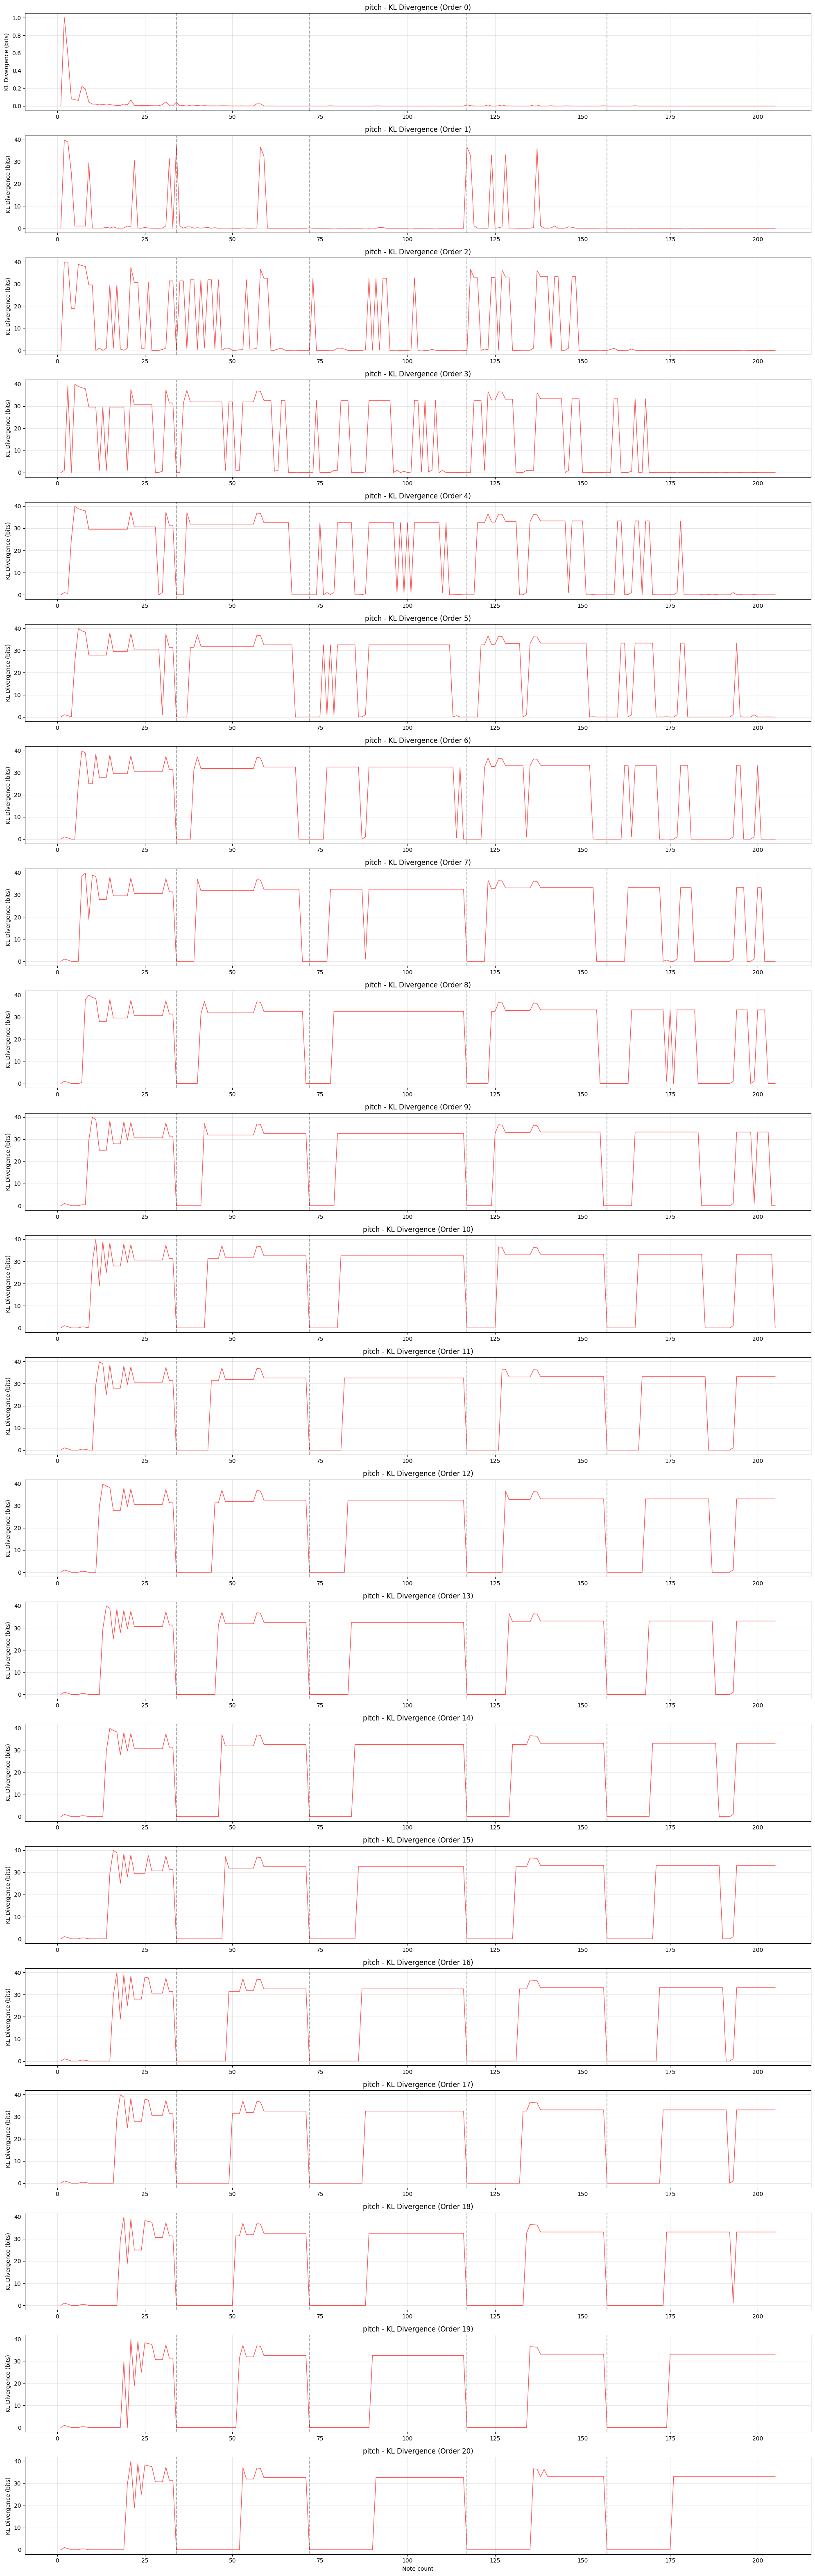

In [261]:
plot_per_order_divergences(data, viewpoint='pitch', metric='KL')

In [262]:
def load_results(path):
    # Handle case where path might be a dict (already loaded data)
    if isinstance(path, dict):
        return path
    
    if os.path.isdir(path):
        # find first .pickle file
        for fname in os.listdir(path):
            if fname.endswith('.pickle'):
                return pickle.load(open(os.path.join(path, fname), 'rb'))
        raise FileNotFoundError(f"No .pickle file found in directory {path}")
    else:
        return pickle.load(open(path, 'rb'))


def process_viewpoint_data(data):
    """Transform raw data into viewpoint-organized structure"""
    # Handle case where data is a string path instead of loaded data
    if isinstance(data, str):
        data = load_results(data)
    
    # Check for meta info and extract file order/piece starts
    if '_meta_' in data:
        meta = data['_meta_']
        file_order = meta.get('file_order', [])
        piece_starts = meta.get('piece_starts', [])
        # Remove meta from main data
        data = {k: v for k, v in data.items() if k != '_meta_'}
    else:
        file_order = list(data.keys())
        piece_starts = []
    
    viewpoint_data = {}
    current_position = 0
    song_starts = [0]  # Always start at position 0
    
    for song_name in file_order:
        if song_name not in data:
            continue
            
        views = data[song_name]
        song_length = 0
        
        for vp, notes in views.items():
            if vp not in viewpoint_data:
                viewpoint_data[vp] = {
                    'IC': [], 
                    'Entropy': [], 
                    'KL_ltm_mean': [],
                    'KL_ltm_std': [],
                    'JS_ltm_mean': [],
                    'JS_ltm_std': [],
                    'KL_ltm_per_order': [],
                    'JS_ltm_per_order': []
                }
            
            if isinstance(notes, list) and len(notes) > 0:
                first_note = notes[0]
                if isinstance(first_note, dict) and 'IC' in first_note:
                    viewpoint_data[vp]['IC'].extend([n['IC'] for n in notes])
                    viewpoint_data[vp]['Entropy'].extend([n['Entropy'] for n in notes])
                    
                    # Store raw per-order data
                    viewpoint_data[vp]['KL_ltm_per_order'].extend([n['KL_ltm_per_order'] for n in notes])
                    if 'JS_ltm_per_order' in first_note:
                        viewpoint_data[vp]['JS_ltm_per_order'].extend([n['JS_ltm_per_order'] for n in notes])
                    
                    # Calculate mean and std for KL divergences
                    for n in notes:
                        if len(n['KL_ltm_per_order']) > 0:
                            kl_array = np.array(n['KL_ltm_per_order'])
                            viewpoint_data[vp]['KL_ltm_mean'].append(np.mean(kl_array))
                            viewpoint_data[vp]['KL_ltm_std'].append(np.std(kl_array))
                        else:
                            viewpoint_data[vp]['KL_ltm_mean'].append(0.0)
                            viewpoint_data[vp]['KL_ltm_std'].append(0.0)
                    
                    # Calculate mean and std for JS divergences
                    for n in notes:
                        if 'JS_ltm_per_order' in n and len(n['JS_ltm_per_order']) > 0:
                            js_array = np.array(n['JS_ltm_per_order'])
                            viewpoint_data[vp]['JS_ltm_mean'].append(np.mean(js_array))
                            viewpoint_data[vp]['JS_ltm_std'].append(np.std(js_array))
                        else:
                            viewpoint_data[vp]['JS_ltm_mean'].append(0.0)
                            viewpoint_data[vp]['JS_ltm_std'].append(0.0)
                    
                    if song_length == 0:
                        song_length = len(notes)
        
        current_position += song_length
        if current_position > song_starts[-1]:  # Only add if we actually advanced
            song_starts.append(current_position)
    
    return viewpoint_data, song_starts[:-1]  # Remove last position


def plot_viewpoint_metrics(data, viewpoint='pitch'):
    """Plot IC, Entropy, KL mean±std, and JS mean±std for a specific viewpoint"""
    # Process data
    viewpoint_data, song_starts = process_viewpoint_data(data)
    
    if viewpoint not in viewpoint_data:
        print(f"Viewpoint '{viewpoint}' not found. Available: {list(viewpoint_data.keys())}")
        return
    
    vp_data = viewpoint_data[viewpoint]
    
    # Create 4x1 subplot grid (separate rows for each metric)
    fig, axes = plt.subplots(4, 1, figsize=(20, 16))
    
    # 1. IC plot
    ax = axes[0]
    if len(vp_data['IC']) > 0:
        note_count = len(vp_data['IC'])
        x_axis = list(range(1, note_count + 1))
        ax.plot(x_axis, vp_data['IC'], color='blue', alpha=0.7, linewidth=1)
        
        # Add vertical lines for piece boundaries
        for start in song_starts[1:]:
            ax.axvline(x=start+1, color='red', linestyle='--', alpha=0.3)
    
    ax.set_title(f'{viewpoint} - Information Content')
    ax.set_xlabel('Note count')
    ax.set_ylabel('IC (bits)')
    ax.grid(True, alpha=0.3)
    
    # 2. Entropy plot
    ax = axes[1]
    if len(vp_data['Entropy']) > 0:
        note_count = len(vp_data['Entropy'])
        x_axis = list(range(1, note_count + 1))
        ax.plot(x_axis, vp_data['Entropy'], color='green', alpha=0.7, linewidth=1)
        
        # Add vertical lines for piece boundaries
        for start in song_starts[1:]:
            ax.axvline(x=start+1, color='red', linestyle='--', alpha=0.3)
    
    ax.set_title(f'{viewpoint} - Entropy')
    ax.set_xlabel('Note count')
    ax.set_ylabel('Entropy (bits)')
    ax.grid(True, alpha=0.3)
    
    # 3. KL divergence mean ± std
    ax = axes[2]
    if len(vp_data['KL_ltm_mean']) > 0:
        note_count = len(vp_data['KL_ltm_mean'])
        x_axis = list(range(1, note_count + 1))
        kl_mean = np.array(vp_data['KL_ltm_mean'])
        kl_std = np.array(vp_data['KL_ltm_std'])
        
        ax.plot(x_axis, kl_mean, color='red', alpha=0.8, linewidth=1, label='Mean KL')
        ax.fill_between(x_axis, kl_mean - kl_std, kl_mean + kl_std, 
                       color='red', alpha=0.2, label='±1 STD')
        
        # Add vertical lines for piece boundaries
        for start in song_starts[1:]:
            if start < note_count:
                ax.axvline(x=start+1, color='black', linestyle='--', alpha=0.3)
    
    ax.set_title(f'{viewpoint} - KL Divergence (Mean ± STD)')
    ax.set_xlabel('Note count')
    ax.set_ylabel('KL Divergence (bits)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 4. JS divergence mean ± std
    ax = axes[3]
    if len(vp_data['JS_ltm_mean']) > 0:
        note_count = len(vp_data['JS_ltm_mean'])
        x_axis = list(range(1, note_count + 1))
        js_mean = np.array(vp_data['JS_ltm_mean'])
        js_std = np.array(vp_data['JS_ltm_std'])
        
        ax.plot(x_axis, js_mean, color='purple', alpha=0.8, linewidth=1, label='Mean JS')
        ax.fill_between(x_axis, js_mean - js_std, js_mean + js_std, 
                       color='purple', alpha=0.2, label='±1 STD')
        
        # Add vertical lines for piece boundaries
        for start in song_starts[1:]:
            if start < note_count:
                ax.axvline(x=start+1, color='black', linestyle='--', alpha=0.3)
    
    ax.set_title(f'{viewpoint} - JS Divergence (Mean ± STD)')
    ax.set_xlabel('Note count')
    ax.set_ylabel('JS Divergence (bits)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def plot_order_divergence(data, viewpoint='pitch', metric='KL', order=0, ymin=None, ymax=None):
    """Plot KL or JS divergence for a specific order with customizable y-axis limits"""
    # Process data
    viewpoint_data, song_starts = process_viewpoint_data(data)
    
    if viewpoint not in viewpoint_data:
        print(f"Viewpoint '{viewpoint}' not found. Available: {list(viewpoint_data.keys())}")
        return None
    
    vp_data = viewpoint_data[viewpoint]
    
    # Select the appropriate metric
    if metric.upper() == 'KL':
        per_order_data = vp_data['KL_ltm_per_order']
        metric_name = 'KL Divergence'
        color = 'red'
    elif metric.upper() == 'JS':
        per_order_data = vp_data['JS_ltm_per_order']
        metric_name = 'JS Divergence'
        color = 'purple'
    else:
        print(f"Invalid metric '{metric}'. Use 'KL' or 'JS'")
        return None
    
    if len(per_order_data) == 0:
        print(f"No {metric} data found for viewpoint '{viewpoint}'")
        return None
    
    # Check if order is valid
    max_available_order = max(len(note_orders) for note_orders in per_order_data if len(note_orders) > 0) - 1
    if order > max_available_order:
        print(f"Order {order} not available. Maximum order is {max_available_order}")
        return None
    
    # Extract values for the specified order across all notes
    order_values = []
    for note_orders in per_order_data:
        if order < len(note_orders):
            order_values.append(note_orders[order])
        else:
            order_values.append(0.0)  # Default if order doesn't exist
    
    # Create single subplot
    fig, ax = plt.subplots(1, 1, figsize=(20, 6))
    
    note_count = len(order_values)
    x_axis = list(range(1, note_count + 1))
    
    # Plot the line for the specified order
    ax.plot(x_axis, order_values, color=color, alpha=0.7, linewidth=1)
    
    # Add vertical lines for piece boundaries
    for start in song_starts[1:]:
        if start < note_count:
            ax.axvline(x=start+1, color='black', linestyle='--', alpha=0.3)
    
    ax.set_title(f'{viewpoint} - {metric_name} (Order {order})')
    ax.set_xlabel('Note count')
    ax.set_ylabel(f'{metric_name} (bits)')
    
    # Set y-axis limits if provided
    if ymin is not None or ymax is not None:
        ax.set_ylim(ymin, ymax)
    
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return order_values


def plot_per_order_divergences(data, viewpoint='pitch', metric='KL'):
    """Plot KL or JS divergence for order 0 only and return all values"""
    return plot_order_divergence(data, viewpoint=viewpoint, metric=metric, order=0, ymin=0, ymax=0.005)


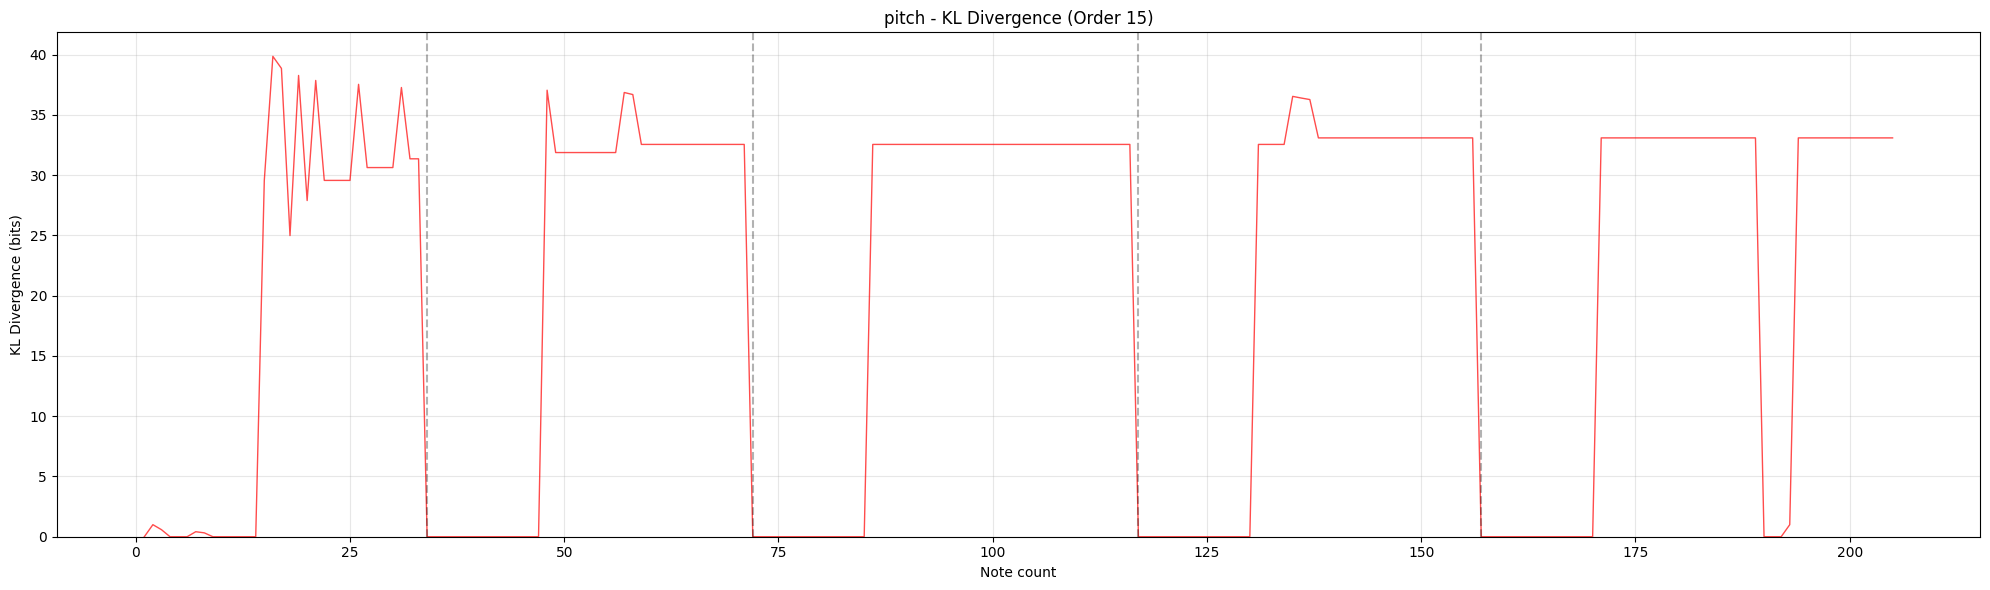

[0.0,
 1.0,
 0.5849625007211562,
 0.0,
 0.0,
 0.0,
 0.4150374992788437,
 0.32192809488736235,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 29.568581616031317,
 39.86313713864835,
 38.86313713864835,
 24.990462258377743,
 38.278174637927194,
 27.897352853986263,
 37.86313713864835,
 29.568581616031317,
 29.568581616031317,
 29.568581616031317,
 29.568581616031317,
 37.541209043760986,
 30.634318448152467,
 30.634318448152467,
 30.634318448152467,
 30.634318448152467,
 37.278174637927194,
 31.36104833964098,
 31.36104833964098,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 37.05578221659074,
 31.880244996317302,
 31.880244996317302,
 31.880244996317302,
 31.880244996317302,
 31.880244996317302,
 31.880244996317302,
 31.880244996317302,
 31.880244996317302,
 36.86313713864835,
 36.69321213720603,
 32.554895329896155,
 32.554895329896155,
 32.554895329896155,
 32.554895329896155,
 32.554895329896155,
 32.554895329896155,
 32.554895329896155,
 32.5548953298961

In [268]:
plot_order_divergence(data, viewpoint='pitch', metric='KL', order=15, ymin=0, ymax=None)

### 